In [2]:
import numpy as np
from google.colab import drive
import scipy.sparse
from sklearn import metrics
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import timeit
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

drive.mount('/content/drive') #connect to your drive
path = '/content/drive/My Drive/ML4fungen/COVID_single_cell/' #your path to the file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
counts_origin = scipy.sparse.csr_matrix(scipy.sparse.load_npz(path+"counts_sub1196.npz"), dtype=np.int16)
counts_origin = counts_origin.transpose()
import gc
gc.collect()

33

In [5]:
counts = counts_origin.toarray()

In [6]:
cell_to_sample = pd.read_csv(path+"GSE158055_cell_annotation.csv.gz", sep=',')

In [7]:
cell_to_sample.shape

(1462702, 4)

In [8]:
cell_to_sample.iloc[:10,]

,cellName,sampleID,celltype,majorType
0,AACAGGGGTCGGATTT-0,S-S070-1,Mono_c1-CD14-CCL3,Mono
1,AACCAACGTCCGAAAG-0,S-S070-1,B_c02-MS4A1-CD27,B
2,AACCTTTGTAGCACGA-0,S-S070-1,B_c01-TCL1A,B
3,AAGCATCTCTATCGCC-0,S-S070-1,Mono_c2-CD14-HLA-DPB1,Mono
4,AATCACGGTCATAAAG-0,S-S070-1,B_c01-TCL1A,B
5,AATCACGGTGGTTCTA-0,S-S070-1,B_c02-MS4A1-CD27,B
6,AATGAAGCAACTGGTT-0,S-S070-1,Macro_c2-CCL3L1,Macro
7,AATGAAGCACCAGCGT-0,S-S070-1,B_c01-TCL1A,B
8,AATGCCATCACCTCGT-0,S-S070-1,T_CD4_c03-ITGA4,CD4
9,AATGGCTCAAGGCTTT-0,S-S070-1,Mono_c1-CD14-CCL3,Mono


In [9]:
cell_to_sample['row_num'] = np.arange(len(cell_to_sample))

In [10]:
sample_to_cell_list = cell_to_sample.groupby('sampleID')['row_num'].apply(np.array).reset_index(name="cell_list")

In [11]:
sample_data = pd.read_csv(path+"GSE158055_sample_metadata.tsv", sep='\t')

In [12]:
sample_data['row_num'] = np.arange(len(sample_data))

In [13]:
classes = []
for _, row in sample_to_cell_list.iterrows():
  severity = sample_data.loc[sample_data['Sample name'] == row['sampleID']]['characteristics: CoVID-19 severity'].item()
  if severity == 'control':
    classes.append(0)
  elif severity == 'mild/moderate':
    classes.append(1)
  else:
    classes.append(2)

In [14]:
classes = np.array(classes)

In [15]:
sample_to_cell_list['classes'] = classes

In [16]:
sample_to_cell_list['row_num'] = np.arange(len(sample_to_cell_list))

In [17]:
phenotypes = sample_to_cell_list.groupby('classes')['row_num'].apply(np.array).reset_index(name="sample_list")

In [18]:
phenotypes

,classes,sample_list
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3..."
2,2,"[150, 151, 152, 153, 154, 155, 156, 157, 158, ..."


In [19]:
control_idx = phenotypes.loc[phenotypes['classes']==0]['sample_list'].item()

In [20]:
mild_idx = phenotypes.loc[phenotypes['classes']==1]['sample_list'].item()

In [21]:
severe_idx = phenotypes.loc[phenotypes['classes']==2]['sample_list'].item()

In [22]:
sample_to_cell_list[:10]

,sampleID,cell_list,classes,row_num
0,S-HC001,"[518643, 518644, 518645, 518646, 518647, 51864...",0,0
1,S-HC002,"[527410, 527411, 527412, 527413, 527414, 52741...",0,1
2,S-HC003,"[605145, 605146, 605147, 605148, 605149, 60515...",0,2
3,S-HC004,"[610082, 610083, 610084, 610085, 610086, 61008...",0,3
4,S-HC005,"[1168641, 1168642, 1168643, 1168644, 1168645, ...",0,4
5,S-HC006,"[1177783, 1177784, 1177785, 1177786, 1177787, ...",0,5
6,S-HC007,"[1183875, 1183876, 1183877, 1183878, 1183879, ...",0,6
7,S-HC008,"[105060, 105061, 105062, 105063, 105064, 10506...",0,7
8,S-HC009,"[108733, 108734, 108735, 108736, 108737, 10873...",0,8
9,S-HC010,"[113113, 113114, 113115, 113116, 113117, 11311...",0,9


In [23]:
def generate_input(sample_to_cell_list, classes, counts, num_cells, num_subsets):
  Xs = np.zeros((num_subsets, num_cells, counts.shape[1]))
  Ys = np.zeros(num_subsets)
  np.random.seed(123) # for reproducibility
  set_indices = np.random.choice(sample_to_cell_list.shape[0], num_subsets, replace=True)
  for i in range(num_subsets):
    index = set_indices[i]
    row = sample_to_cell_list.iloc[index]
    indices = np.random.choice(len(row['cell_list']), num_cells, replace=True)
    Xs[i] = counts[row['cell_list'][indices]]
    Ys[i] = 0 if classes[index] == 0 else 1
  return Xs, Ys

In [24]:
control_n = control_idx.shape[0]
np.random.seed(1234)
control_perm = np.random.permutation(control_idx)
train_control_idx = control_perm[:int(np.ceil(0.8 * control_n))]
val_control_idx = control_perm[int(np.ceil(0.8 * control_n)):int(np.ceil(0.9 * control_n))]
test_control_idx = control_perm[int(np.ceil(0.9 * control_n)):]
x_train_control, y_train_control = generate_input(sample_to_cell_list.iloc[train_control_idx], classes[train_control_idx], counts, 1024, 800)
x_val_control, y_val_control = generate_input(sample_to_cell_list.iloc[val_control_idx], classes[val_control_idx], counts, 1024, 100)
x_test_control, y_test_control = generate_input(sample_to_cell_list.iloc[test_control_idx], classes[test_control_idx], counts, 1024, 100)

In [25]:
sample_idx = np.append(mild_idx, severe_idx)
sample_n = sample_idx.shape[0]
np.random.seed(12345)
sample_perm = np.random.permutation(sample_idx)
train_sample_idx = sample_perm[:int(np.ceil(0.8 * sample_n))]
val_sample_idx = sample_perm[int(np.ceil(0.8 * sample_n)):int(np.ceil(0.9 * sample_n))]
test_sample_idx = sample_perm[int(np.ceil(0.9 * sample_n)):]
x_train_sample, y_train_sample = generate_input(sample_to_cell_list.iloc[train_sample_idx], classes[train_sample_idx], counts, 1024, 800)
x_val_sample, y_val_sample = generate_input(sample_to_cell_list.iloc[val_sample_idx], classes[val_sample_idx], counts, 1024, 100)
x_test_sample, y_test_sample = generate_input(sample_to_cell_list.iloc[test_sample_idx], classes[test_sample_idx], counts, 1024, 100)

In [26]:
train_perm = np.random.permutation(x_train_control.shape[0]+x_train_sample.shape[0])
X_train = np.concatenate((x_train_control, x_train_sample), axis=0).astype(np.float32)[train_perm]
y_train = np.concatenate((y_train_control, y_train_sample), axis=0).astype(np.float32)[train_perm]

val_perm = np.random.permutation(x_val_control.shape[0]+x_val_sample.shape[0])
X_val = np.concatenate((x_val_control, x_val_sample), axis=0).astype(np.float32)[val_perm]
y_val = np.concatenate((y_val_control, y_val_sample), axis=0).astype(np.float32)[val_perm]

test_perm = np.random.permutation(x_test_control.shape[0]+x_test_sample.shape[0])
X_test = np.concatenate((x_test_control, x_test_sample), axis=0).astype(np.float32)[test_perm]
y_test = np.concatenate((y_test_control, y_test_sample), axis=0).astype(np.float32)[test_perm]

In [27]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data, label):
        super(Dataset, self).__init__()
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [28]:
train_dataset = Dataset(X_train, y_train)
validation_dataset = Dataset(X_val, y_val)
test_dataset = Dataset(X_test, y_test)

In [29]:
class Pool(nn.Module):
    def __init__(
        self,
        dim,
        pool_type='max'
    ):
        super(Pool, self).__init__()
        self.dim = dim
        self.pool_type = pool_type

    def forward(self, x, keepdim=True):
        if self.pool_type == 'mean':
            xm = x.mean(self.dim, keepdim=keepdim)
        elif self.pool_type == 'max':
            xm, _ = x.max(self.dim, keepdim=keepdim)
        elif self.pool_type == 'sum':
            xm = x.sum(self.dim, keepdim=keepdim)
        else:
            raise NotImplementedError(f"pool type: {self.pool} is not supported")
        return xm

In [30]:
class PermEqui2(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        pool: str = 'max'
    ):
        super(PermEqui2, self).__init__()
        self.Gamma = nn.Linear(in_dim, out_dim)
        self.Lambda = nn.Linear(in_dim, out_dim, bias=False)
        self.pool_module = Pool(dim=1, pool_type=pool)

    def forward(self, x):
        xm = self.pool_module(x, keepdim=True)
        xm = self.Lambda(xm)
        x = self.Gamma(x)
        # residual connection
        x = x - xm
        return x


In [31]:
class CytoSetModel(nn.Module):
    def __init__(self, dims, nblock, pool='max', out_pool='max', dropout = 0.5):
        super(CytoSetModel, self).__init__()
        self.dims = dims
        self.nblock = nblock
        self.pool = pool
        self.out_pool = out_pool
        self.dropout = dropout

        layers = []
        for i in range(self.nblock):
            layers.append(PermEqui2(self.dims[i], self.dims[i+1], self.pool))
            layers.append(nn.ELU(inplace=True))
        self.enc = nn.Sequential(*layers)

        dnns = []
        for i in range(len(dims)-self.nblock-1):
            if i == len(dims)-self.nblock-2:
                dnns.append(
                    nn.Sequential(
                        nn.Dropout(p=self.dropout),
                        nn.Linear(self.dims[i+self.nblock], self.dims[i+self.nblock+1]),
                        nn.ELU(inplace=True),
                        nn.Dropout(p=self.dropout),
                        nn.Linear(self.dims[i+self.nblock+1], 1)
                        )
                    )
            else:
                dnns.append(
                    nn.Sequential(
                        nn.Dropout(p=self.dropout),
                        nn.Linear(self.dims[i+self.nblock], self.dims[i+self.nblock]),
                        nn.ELU(inplace=True),
                        nn.Dropout(p=self.dropout),
                        nn.Linear(self.dims[i+self.nblock], self.dims[i+self.nblock+1])
                        )
                    )
        self.dec = nn.Sequential(*dnns)
        self.out_pool = Pool(dim=1, pool_type=self.out_pool)

    def forward(self, x):
        # set encoding
        x = self.enc(x)
        # pooling
        x = self.out_pool(x, keepdim=False)
        # feed forward
        x = self.dec(x).view(-1)
        x = torch.sigmoid(x)
        return x

In [43]:
model = CytoSetModel([X_train.shape[2], 512, 128, 128, 128, 32, 32], 4, dropout=0.5)
model.to(device)
model

CytoSetModel(
  (enc): Sequential(
    (0): PermEqui2(
      (Gamma): Linear(in_features=1196, out_features=512, bias=True)
      (Lambda): Linear(in_features=1196, out_features=512, bias=False)
      (pool_module): Pool()
    )
    (1): ELU(alpha=1.0, inplace=True)
    (2): PermEqui2(
      (Gamma): Linear(in_features=512, out_features=128, bias=True)
      (Lambda): Linear(in_features=512, out_features=128, bias=False)
      (pool_module): Pool()
    )
    (3): ELU(alpha=1.0, inplace=True)
    (4): PermEqui2(
      (Gamma): Linear(in_features=128, out_features=128, bias=True)
      (Lambda): Linear(in_features=128, out_features=128, bias=False)
      (pool_module): Pool()
    )
    (5): ELU(alpha=1.0, inplace=True)
    (6): PermEqui2(
      (Gamma): Linear(in_features=128, out_features=128, bias=True)
      (Lambda): Linear(in_features=128, out_features=128, bias=False)
      (pool_module): Pool()
    )
    (7): ELU(alpha=1.0, inplace=True)
  )
  (dec): Sequential(
    (0): Sequentia

In [33]:
def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []

    for (x, y) in dataloader:
        (x, y) = ( x.to(device), y.to(device) ) 
        output = model(x)
        output = output.squeeze()
        loss = F.binary_cross_entropy(output, y, reduction='mean')
        if train_flag: 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().cpu().numpy())  
    
    return( np.mean(losses), np.mean(accuracies) )

In [34]:
def train_model(model, train_dataset, validation_dataset, optimizer, epochs=100, patience=10, verbose=True):
    model.to(device)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, num_workers = 0)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=20)

    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'model_checkpoint.pt' # to save the best model fit to date
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        if verbose:
          print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
              (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))

    return model, train_accs, val_accs

Epoch 1 took 3.62s. Train loss: 0.9688 acc: 0.5175. Val loss: 0.6618 acc: 0.5800. Patience left: 20
Epoch 2 took 3.65s. Train loss: 0.7353 acc: 0.5881. Val loss: 0.6085 acc: 0.6850. Patience left: 20
Epoch 3 took 3.58s. Train loss: 0.6995 acc: 0.6262. Val loss: 0.5658 acc: 0.7450. Patience left: 20
Epoch 4 took 3.57s. Train loss: 0.5955 acc: 0.6837. Val loss: 0.5418 acc: 0.7150. Patience left: 20
Epoch 5 took 3.58s. Train loss: 0.5260 acc: 0.7437. Val loss: 0.4676 acc: 0.7750. Patience left: 20
Epoch 6 took 3.61s. Train loss: 0.4374 acc: 0.8025. Val loss: 0.4480 acc: 0.7650. Patience left: 20
Epoch 7 took 3.61s. Train loss: 0.3975 acc: 0.8288. Val loss: 0.5144 acc: 0.7350. Patience left: 19
Epoch 8 took 3.61s. Train loss: 0.3291 acc: 0.8844. Val loss: 0.6395 acc: 0.7500. Patience left: 18
Epoch 9 took 3.58s. Train loss: 0.2601 acc: 0.9069. Val loss: 0.6058 acc: 0.7650. Patience left: 17
Epoch 10 took 3.56s. Train loss: 0.2172 acc: 0.9306. Val loss: 0.6053 acc: 0.8000. Patience left: 16

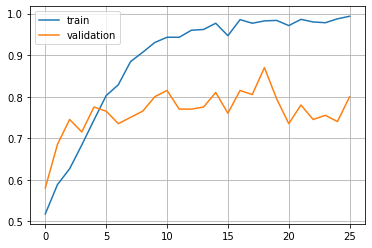

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, betas=(0.9, 0.999), weight_decay=1e-2)
model, train_accs, val_accs = train_model(model, train_dataset, validation_dataset, optimizer, patience=20)
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="validation")
plt.legend() 
plt.grid(which="both")

In [36]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20)

In [45]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
test_acc

0.74

In [49]:
outputs = []
for x, _ in test_dataloader:
    x = x.to(device)
    output = model(x).squeeze()
    output_np = output.detach().cpu().numpy()
    outputs.append(output_np)
output_np = np.concatenate(outputs)

In [50]:
auroc = metrics.roc_auc_score(y_test, output_np)
auroc

0.8203999999999999

In [51]:
precision, recall, _ = metrics.precision_recall_curve(y_test, output_np)
aupr = metrics.auc(recall, precision)
aupr

0.8567246032541453